# Libraries

In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from math import floor
import seaborn as sns
import yfinance as yf
from bandit_library import *

# Defining Inputs

In [3]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 150
m = 50

trade_start_time = datetime.datetime(2023,1,15,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1wk':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

##INTERVAL AND TRADING PERIOD##

In [4]:
##STOCKS##

tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA',
           'PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
n_assets = len(tickers)

##STOCKS##

In [5]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-08-18 17:30:00
start date   : 2023-03-06 17:30:00


# Brief Co-Dependence Analysis

Text(0.5, 1.0, 'Covariance Matrix')

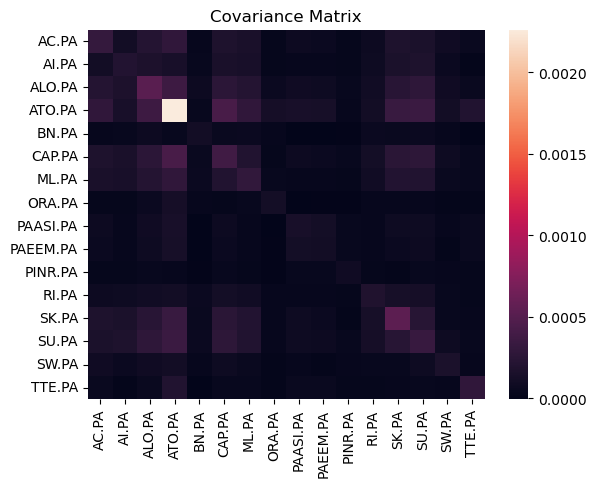

In [6]:
sns.heatmap(hist_returns.cov())
plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

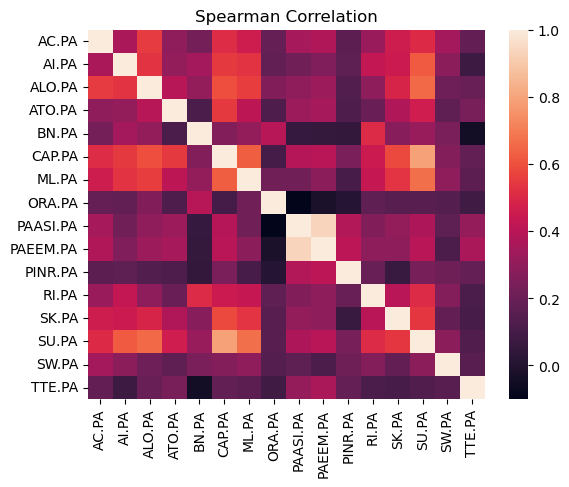

In [7]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [8]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [9]:
k=1

In [10]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

The next step is to decomposse of the covariance matrix :

In [11]:
Lambda, H = eigen_decomposition(Sigma)
Lambdas = np.diag(Lambda)

- Lambda corresponds to $\Lambda_k$
- Lambdas is a numpy array containing all the eigenvalues (the diagonal of $\Lambda_k$)
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [12]:
Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
Lambdas_norm = np.diag(Lambda_norm)

In [13]:
Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

- Lambda_tilde and Sigma_tilde corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

In [14]:
portfolio_returns = np.matmul(np.transpose(H),np.array(E_R))

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [15]:
SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)
SR

array([ 17.34270774,  27.76245013,  53.84213529,  58.26656268,
        66.70202102,  68.22446962,  77.75699892,  81.63942375,
        91.19920094,  96.66461126, 101.78896314, 115.72474771,
       135.81921245, 141.72058017, 161.32679526, 580.03133503])

# All in One - Algorithm Orthogonal Bandit Portfolio

In [16]:
interval = '1d'
tau = 150
m = 30
l = 8 #n_assets / 2 looks good for small n_assets

In [17]:
def run_obp(interval,l,m,tau):
    weights = []
    returns = []
    returnsEW = []
    CW_OBP_list =[]
    CW_EW_list=[]
    Theta = []
    choices_inf = l*[0]
    choices_sup = (n_assets-l)*[0]
    data = Data(tickers)
    hist_returns = data.get_data(hist_start_time,hist_end_time,interval)
    
    for k in range(1,m+1):
        
        #Step 1 : Estimate Average Return and Covariance Matrix of asset returns
        E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

        #Step 2 : Principal Component Decomposition 
        Lambda, H = eigen_decomposition(Sigma)
        Lambdas = np.diag(Lambda)

        #Step 3 : Normalize
        Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
        Lambdas_norm = np.diag(Lambda_norm)
        Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

        #Step 4 : Compute the Sharpe Ratio of each arm
        SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)

        #Step 5 : Compute the adjusted reward function of each arm
        SR_inf,SR_sup,Lambda_inf,Lambda_sup,H_inf,H_sup = factor_decomposition(Lambda_norm,H_norm,SR,l)
        adjusted_rewards_inf = objective_function(n_assets,SR_inf,k,tau,choices_inf)
        adjusted_rewards_sup = objective_function(n_assets,SR_sup,k,tau,choices_sup)

        #Step 6 : Select an arm for each subset 
        arm_inf = ucb_policy(n_assets,SR_inf,k,tau,choices_inf)
        arm_sup = ucb_policy(n_assets,SR_sup,k,tau,choices_sup)
        choices_inf[arm_inf]+=1 #updating k_i
        choices_sup[arm_sup]+=1

        #Step 7 : Calculate the portfolio weights and return
        Thetak = np.diag(Lambda_inf)[arm_inf]/(np.diag(Lambda_inf)[arm_inf]+np.diag(Lambda_sup[:,l:])[arm_sup])
        Theta.append(Thetak)
        w_k = (1-Thetak)*H_inf[:,arm_inf] + Thetak*H_sup[:,arm_sup]
        weights.append(w_k)
        mu_k  = np.matmul(np.transpose(w_k),E_R)-1
    #     mu_k  = np.sum(w_k*E_R)-1  #both mu_k are equivalent 
        returns.append(mu_k)
        mu_k_EW = np.sum(E_R/n_assets)-1
    #     mu_k_EW = hist_returns[(hist_returns.index>trade_start_time+datetime.timedelta(days=k))&(hist_returns.index<trade_start_time+datetime.timedelta(days=k+1))].mean().mean()
        returnsEW.append(mu_k_EW)
        CW_OBP_list.append(np.product(np.array(returns)+1))
        CW_EW_list.append(np.product(np.array(returnsEW)+1))
    return(returns,returnsEW,CW_OBP_list,CW_EW_list,weights)

In [18]:
returns,returnsEW,CW_OBP_list,CW_EW_list,weights = run_obp(interval=interval,tau=tau,l=l,m=m)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-08-18 17:30:00
start date   : 2023-03-06 17:30:00


In [19]:
mean_return = np.mean(np.array(returns)) # +1 if gross, nothing if net return
mean_return_ew = np.mean(np.array(returnsEW))
std = np.sqrt((1/(m-1))*np.sum((returns-mean_return)**2))
std_ew = np.sqrt((1/(m-1))*np.sum((returnsEW-mean_return_ew)**2))
CW_OBP = np.product(np.array(returns)+1)
CW_EW = np.product(np.array(returnsEW)+1)
print('PORTFOLIO INFOS')
print('------------')
print('OBP - Sharpe Ratio :',mean_return/std)
print('EW - Sharpe Ratio :',mean_return_ew/std_ew)
print('------------')
print('Cumulative Wealth OBP',CW_OBP)
print('Cumulative Wealth EW',CW_EW)

PORTFOLIO INFOS
------------
OBP - Sharpe Ratio : 0.26847401276978894
EW - Sharpe Ratio : 4.144711623578916
------------
Cumulative Wealth OBP 1.8273869294933187
Cumulative Wealth EW 1.0307153190282499


Text(0.5, 1.0, 'Comparing OBP and EW Portfolios CW')

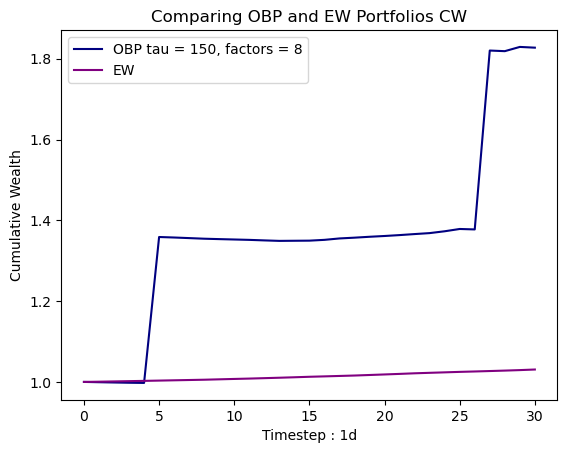

In [20]:
sns.lineplot(x=np.arange(0,m+1,1),y=[1]+CW_OBP_list,color='navy',label=f'OBP tau = {tau}, factors = {l}')
sns.lineplot(x=np.arange(0,m+1,1),y=[1]+CW_EW_list,color='purple',label='EW')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep : {interval}')
plt.title('Comparing OBP and EW Portfolios CW')

In [26]:
E_R

AC.PA       1.000872
AI.PA       1.000509
ALO.PA      1.001677
ATO.PA      1.002894
BN.PA       0.999324
CAP.PA      0.999334
ML.PA       1.001219
ORA.PA      0.999661
PAASI.PA    0.999842
PAEEM.PA    0.999764
PINR.PA     0.998980
RI.PA       1.000048
SK.PA       1.001804
SU.PA       1.000955
SW.PA       1.000774
TTE.PA      1.001328
dtype: float64

In [28]:
hist_returns

,AC.PA,AI.PA,ALO.PA,ATO.PA,BN.PA,CAP.PA,ML.PA,ORA.PA,PAASI.PA,PAEEM.PA,PINR.PA,RI.PA,SK.PA,SU.PA,SW.PA,TTE.PA
Date,,,,,,,,,,,,,,,,
2022-08-19,0.972393,1.000586,0.982063,0.975207,0.999441,0.994127,0.983228,1.005036,0.994789,0.993172,0.991115,1.003338,1.009690,0.983043,0.987145,0.997917
2022-08-22,0.974763,0.967326,0.973973,0.954802,0.992171,0.971268,0.967629,0.997687,1.002794,1.003005,0.995106,0.994115,0.983365,0.955985,0.987469,1.006643
2022-08-23,1.001618,0.992124,0.997187,1.013807,0.994740,0.998618,0.995393,0.994591,0.999608,1.000908,1.004526,0.980438,1.001301,0.995956,0.986066,1.032428
2022-08-24,0.995961,1.009618,1.005642,1.004377,1.010576,1.009967,1.007849,0.987182,1.004790,1.005125,1.009055,1.011289,0.994802,1.010620,1.000000,0.979547
2022-08-25,1.006083,0.998790,0.982235,0.991283,0.997757,1.000274,0.997604,0.998426,1.013176,1.011912,0.990167,0.992991,1.001959,0.983774,0.998486,1.007457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,0.991808,0.993140,1.017550,1.007496,0.990512,1.007363,0.984440,0.993922,0.993187,0.998287,0.994071,0.988006,1.013902,1.000658,0.987174,0.989024
2023-03-01,0.971093,0.991764,0.993173,1.050223,0.996243,1.002811,0.998150,0.995923,1.015175,1.010640,1.002468,0.993677,0.964351,1.009466,0.992478,0.989927
2023-03-02,0.999019,1.001607,0.997829,1.001771,1.011689,0.998879,0.992924,1.000186,1.008793,1.005288,1.008412,1.024179,1.012322,0.996874,1.000919,1.019662


In [29]:
def James_Stein(hist,k,tau,interval,trade_start_time):
    current_time_k = trade_start_time + datetime.timedelta(days=k-1)
    if interval == '1wk':
        current_time_k = trade_start_time + datetime.timedelta(days=7*k)
    hist_temp = hist[(hist.index > current_time_k - datetime.timedelta(days=tau))&(hist.index < current_time_k)]
#     sigma_hat = 
#     js_estimate = (1-(n_assets-2-))
    return 0 

#     return(js_estimate)

In [30]:
#improved james stein